In [12]:
import pandas as pd
import sqlalchemy
from matplotlib import pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import copy
pd.options.mode.chained_assignment = None

In [13]:
df = pd.read_csv("/home/memari/jhu_centering/tables/calls_cleaned.csv",parse_dates=['date'])

In [15]:
col = df.columns.tolist()
col.insert(0,'day')
print(col)

['day', 'device_id', 'date', 'incoming_time', 'incoming_freq', 'outgoing_time', 'outgoing_freq', 'missing_time', 'missing_freq']


In [16]:
# find the first day
def find_first_day(device_id, df):
    df_target = df[df['device_id']==device_id]
    return min(df_target['date'])
def halve(df):
    first_day = {device_id:find_first_day(device_id, df) 
                 for device_id in set(df['device_id'].tolist())
                if find_first_day(device_id, df)>=datetime.date(year=2022,month=11,day=11)}
    df = df[df['device_id'].isin(first_day)]
    df['day'] = df.apply(lambda x: 1+(x['date']-first_day[x['device_id']]).days, axis = 1)
    df_1_14 = df[df['day']<=14]
    df_15_28 = df[(df['day']>14) & (df['day']<=28)]
    return df_1_14,df_15_28
df_1_14,df_15_28 = halve(df)

In [17]:
df_1_14 = df_1_14[col]
df_15_28 = df_15_28[col]

,day,device_id,date,incoming_time,incoming_freq,outgoing_time,outgoing_freq,missing_time,missing_freq
0,1,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-19,625.0,3,24.0,2,0.0,0
1,2,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-20,1876.0,7,1830.0,14,1176.0,2
2,3,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-21,5157.0,10,803.0,3,0.0,0
3,4,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-22,1403.0,4,335.0,16,954.0,2
4,5,00e17b8a-4b0f-4230-bd26-3df2853e8916,2022-12-23,4783.0,6,996.0,4,0.0,0
...,...,...,...,...,...,...,...,...,...
2534,10,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-17,0.0,0,1465.0,7,265.0,1
2535,11,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-18,0.0,0,80.0,1,0.0,0
2536,12,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-19,1613.0,6,81.0,2,0.0,0
2537,13,ffe96eaa-8909-4958-a34e-0ed1fe68f9bd,2022-12-20,1382.0,8,510.0,7,3.0,1


In [21]:
# get the groups form the survey data
df_group = pd.read_csv('/data/meditation/majid/surveys/0.csv',
                       skiprows=[1, 2])[['Study ID', 'Group']]
df_group.columns = ['survey_id', 'group']
df_id = pd.read_csv('/home/memari/jhu_centering/tables/id.csv')

df_group = df_id.merge(df_group, on='survey_id', how='left')
df_group.rename(columns={'device_id1': 'device_id'}, inplace=True)
df_group = df_group.rename(columns={'group_x': 'group'})


In [22]:
df_1_14 = df_1_14.merge(df_group[['device_id', 'group']],
                   on='device_id', how='left')
df_15_28 = df_15_28.merge(df_group[['device_id', 'group']],
                   on='device_id', how='left')

In [23]:
grouped_1_14 = df_1_14 .groupby(['group'])
df_dict = {group: data for group, data in grouped_1_14}
active_control_1_14 = df_dict['Active Control']
experimental_condition_1_14 = df_dict['Experimental Condition']
passive_control_1_14 = df_dict['Passive Control']

In [24]:
grouped_15_28 = df_15_28 .groupby(['group'])
df_dict = {group: data for group, data in grouped_15_28}
active_control_15_28 = df_dict['Active Control']
experimental_condition_15_28 = df_dict['Experimental Condition']
passive_control_15_28 = df_dict['Passive Control']

In [25]:
to_remove = ['day', 'device_id', 'date']
my_list = [item for item in col if item not in to_remove]

active_control: t-statistic=-1.33 and p-value=0.18
experimental_condition: t-statistic=-1.33 and p-value=0.39
passive_control: t-statistic=-1.33 and p-value=0.59


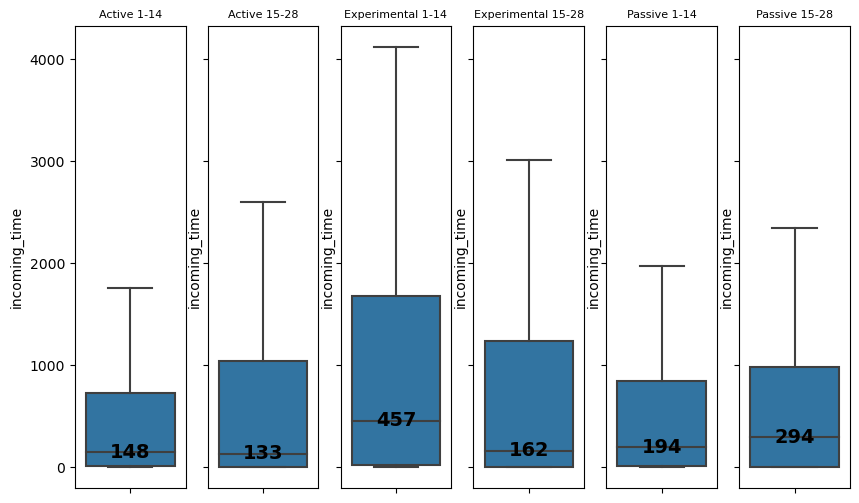

active_control: t-statistic=-0.67 and p-value=0.50
experimental_condition: t-statistic=-0.67 and p-value=0.01
passive_control: t-statistic=-0.67 and p-value=0.89


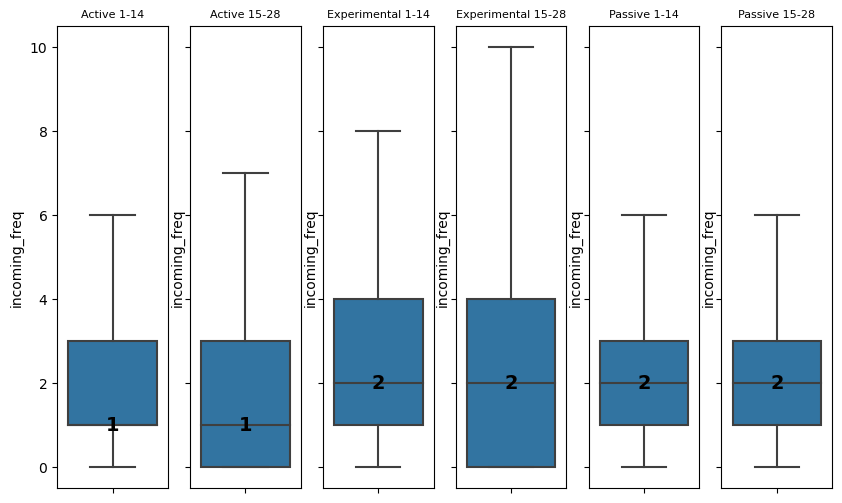

active_control: t-statistic=-0.03 and p-value=0.98
experimental_condition: t-statistic=-0.03 and p-value=0.16
passive_control: t-statistic=-0.03 and p-value=0.96


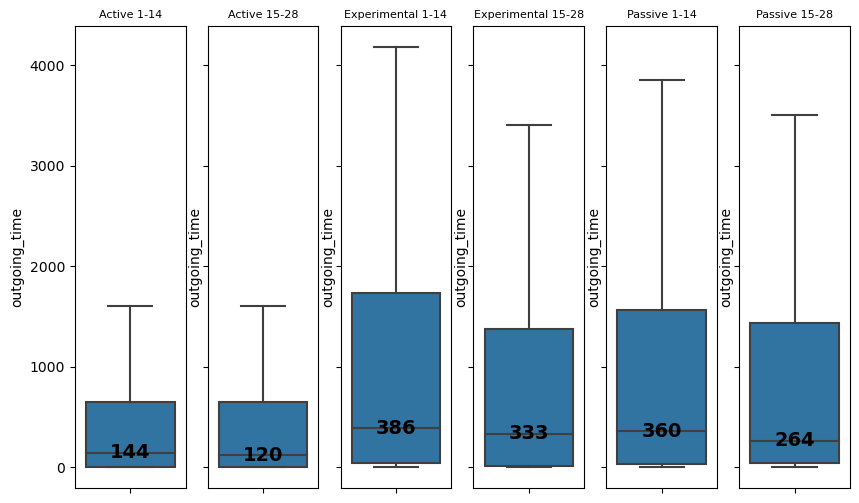

active_control: t-statistic=-0.08 and p-value=0.94
experimental_condition: t-statistic=-0.08 and p-value=0.01
passive_control: t-statistic=-0.08 and p-value=0.65


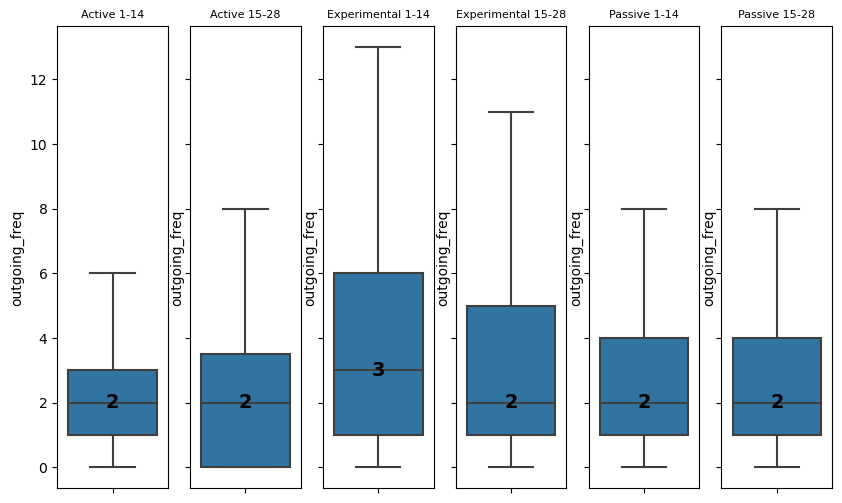

active_control: t-statistic=2.00 and p-value=0.05
experimental_condition: t-statistic=2.00 and p-value=0.35
passive_control: t-statistic=2.00 and p-value=0.58


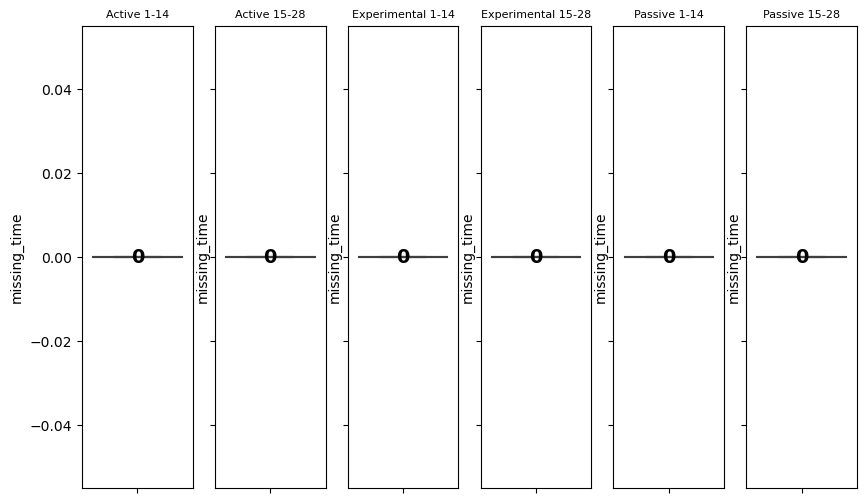

active_control: t-statistic=-0.57 and p-value=0.57
experimental_condition: t-statistic=-0.57 and p-value=0.26
passive_control: t-statistic=-0.57 and p-value=0.27


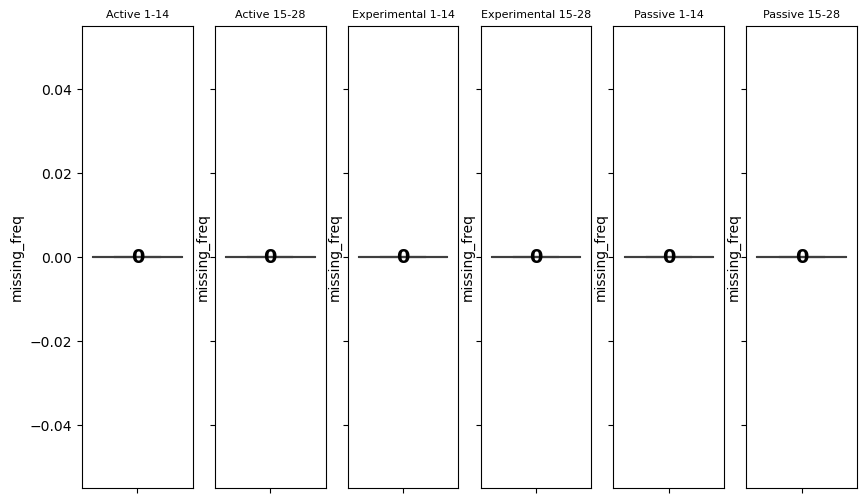

In [26]:
for clm in my_list:
    fig, (ax1, ax2, ax3,ax4,ax5,ax6) = plt.subplots(1, 6, figsize=(10, 6), sharey=True)
    sns.boxplot(y=active_control_1_14[clm], orient="v", showfliers=False, ax=ax1)
    sns.boxplot(y=active_control_15_28[clm], orient="v", showfliers=False, ax=ax2)
    sns.boxplot(y=experimental_condition_1_14[clm],orient="v", showfliers=False, ax=ax3)
    sns.boxplot(y=experimental_condition_15_28[clm],orient="v", showfliers=False, ax=ax4)
    sns.boxplot(y=passive_control_1_14[clm], orient="v", showfliers=False, ax=ax5)
    sns.boxplot(y=passive_control_15_28[clm], orient="v", showfliers=False, ax=ax6)

    ax1.set_title("Active 1-14", fontsize=8)
    m1 = int(active_control_1_14[clm].median())
    ax1.text(0, m1, m1, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax2.set_title("Active 15-28", fontsize=8)
    m2 = int(active_control_15_28[clm].median())
    ax2.text(0, m2, m2, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax3.set_title("Experimental 1-14", fontsize=8)
    m3 = int(experimental_condition_1_14[clm].median())
    ax3.text(0, m3, m3, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax4.set_title("Experimental 15-28", fontsize=8)
    m4 = int(experimental_condition_15_28[clm].median())
    ax4.text(0, m4, m4, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax5.set_title("Passive 1-14", fontsize=8)
    m5 = int(passive_control_1_14[clm].median())
    ax5.text(0, m5, m5, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})
    ax6.set_title("Passive 15-28", fontsize=8)
    m6 = int(passive_control_15_28[clm].median())
    ax6.text(0, m6, m6, ha='center', va='center',fontsize=14, fontdict={'fontweight': 'bold'})

    t, p = ttest_ind(active_control_1_14[clm], active_control_15_28[clm])
    print('active_control: t-statistic={:.2f} and p-value={:.2f}'.format(t, p))
    stat, p = ttest_ind(experimental_condition_1_14[clm], experimental_condition_15_28[clm])
    print('experimental_condition: t-statistic={:.2f} and p-value={:.2f}'.format(t, p))
    stat, p = ttest_ind(passive_control_1_14[clm], passive_control_15_28[clm])
    print('passive_control: t-statistic={:.2f} and p-value={:.2f}'.format(t, p))
    plt.show()